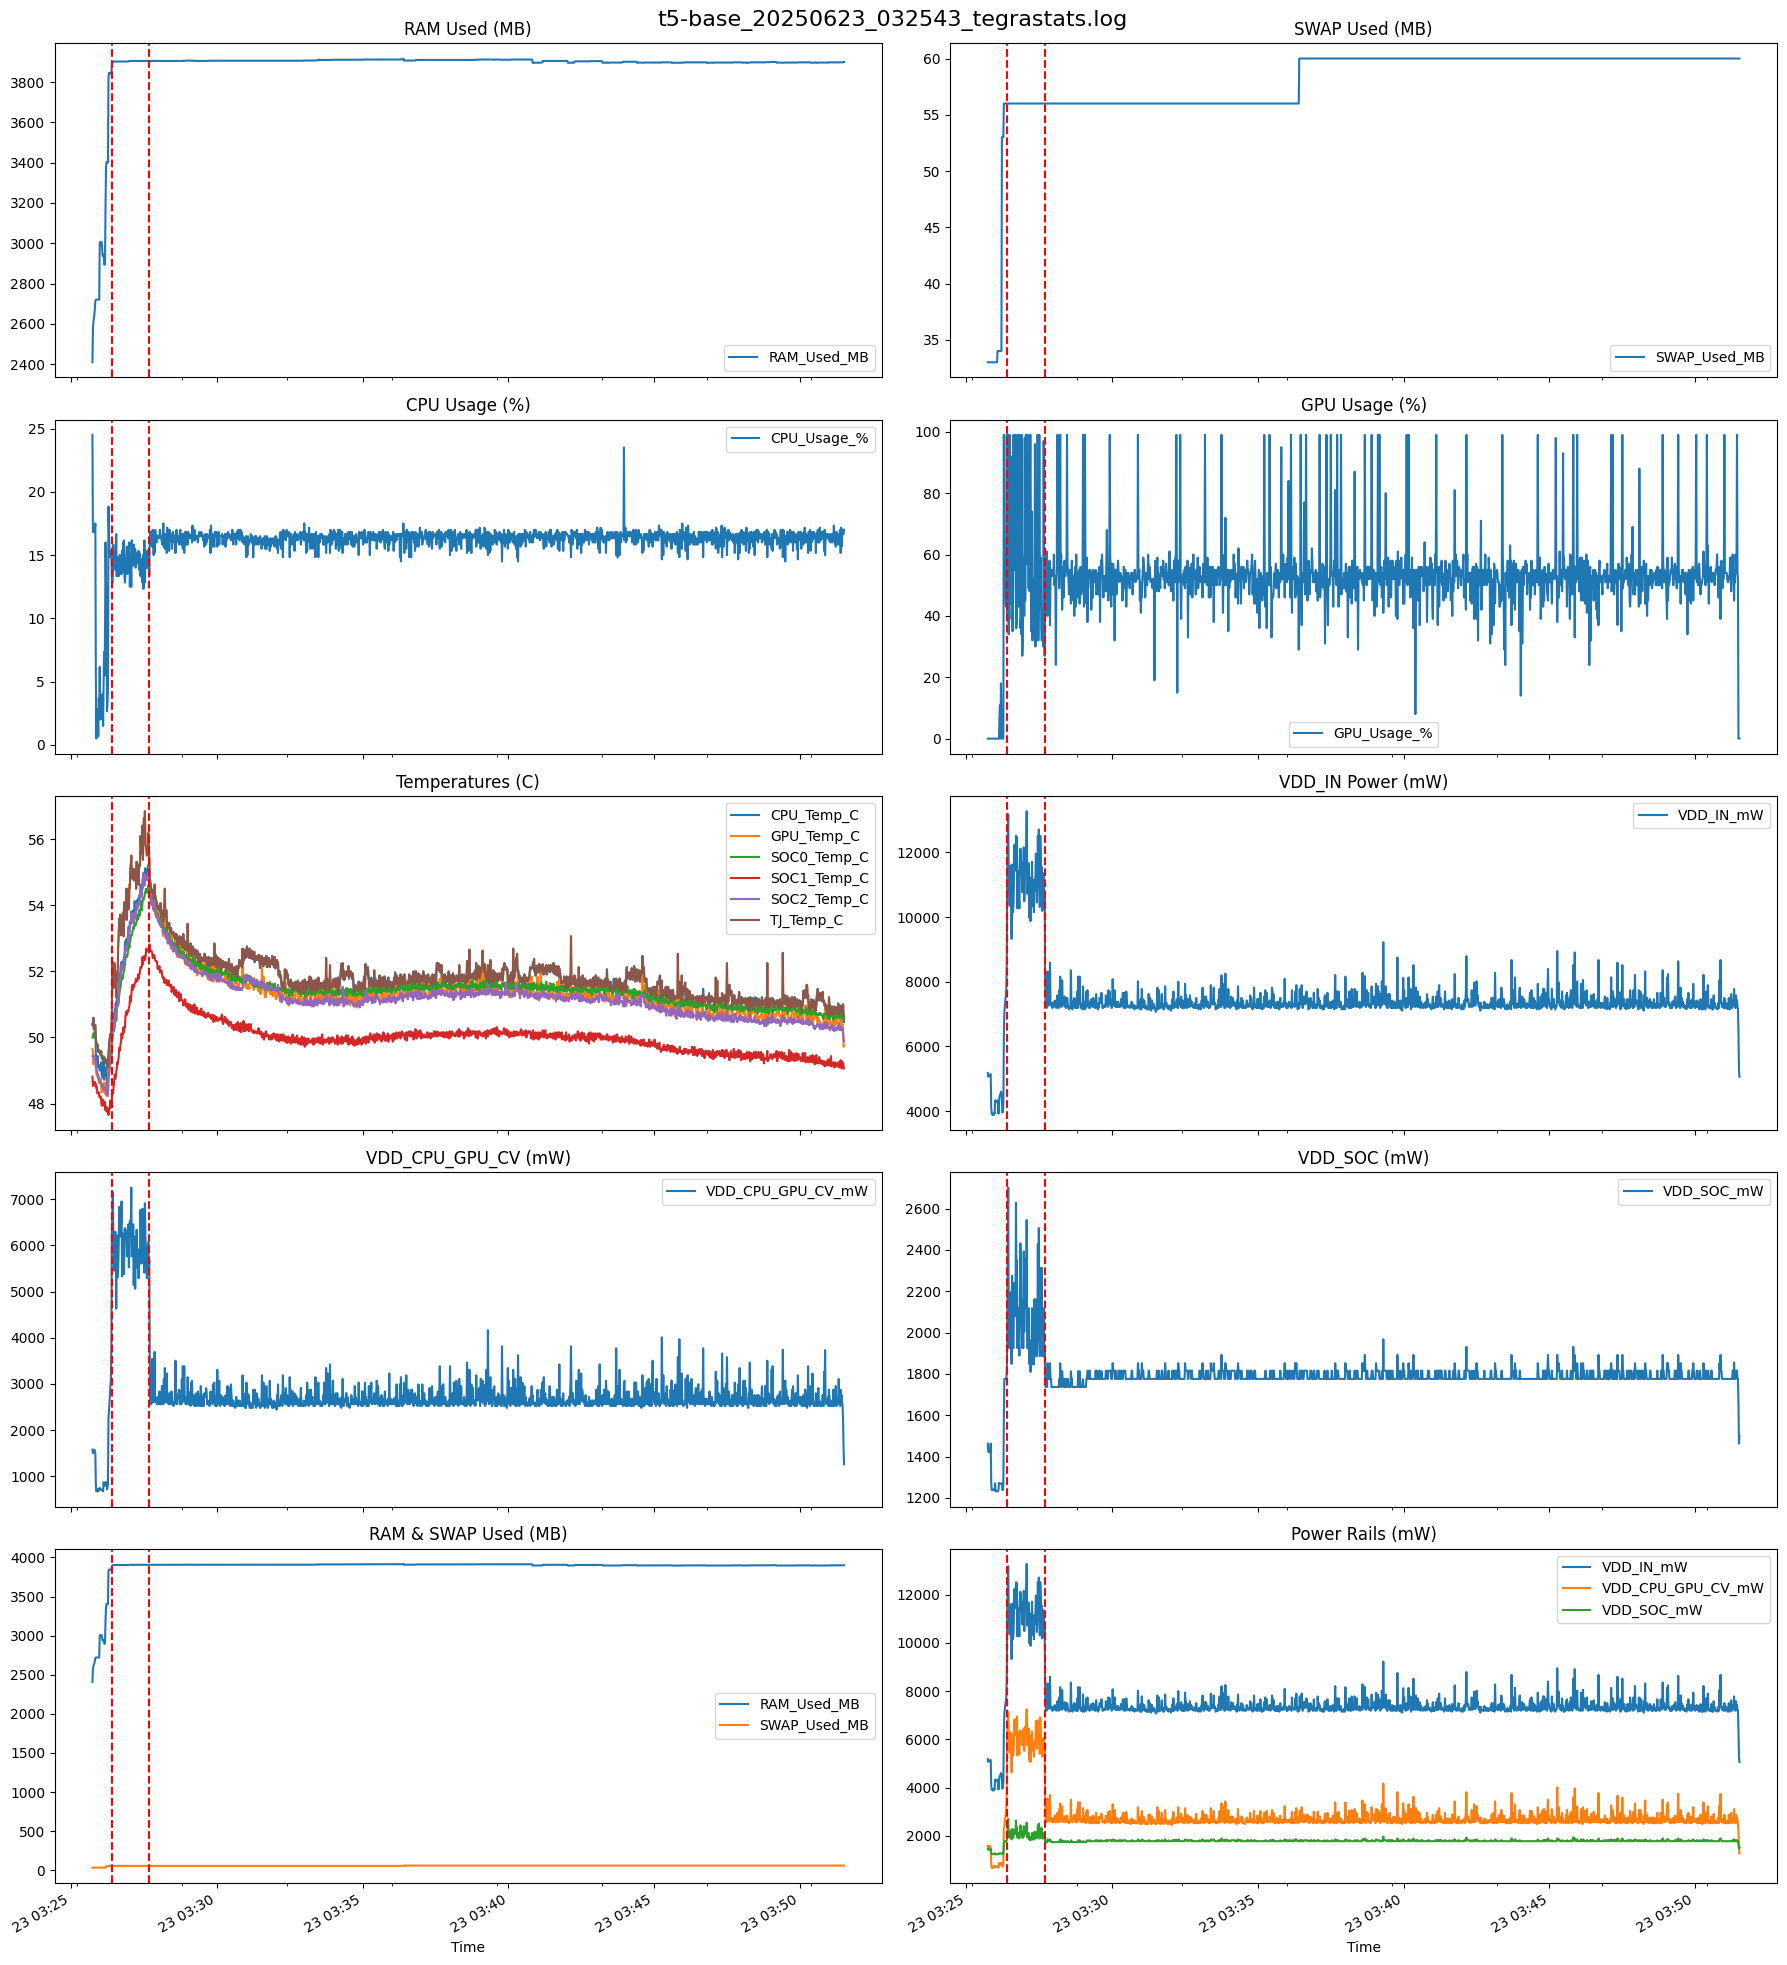

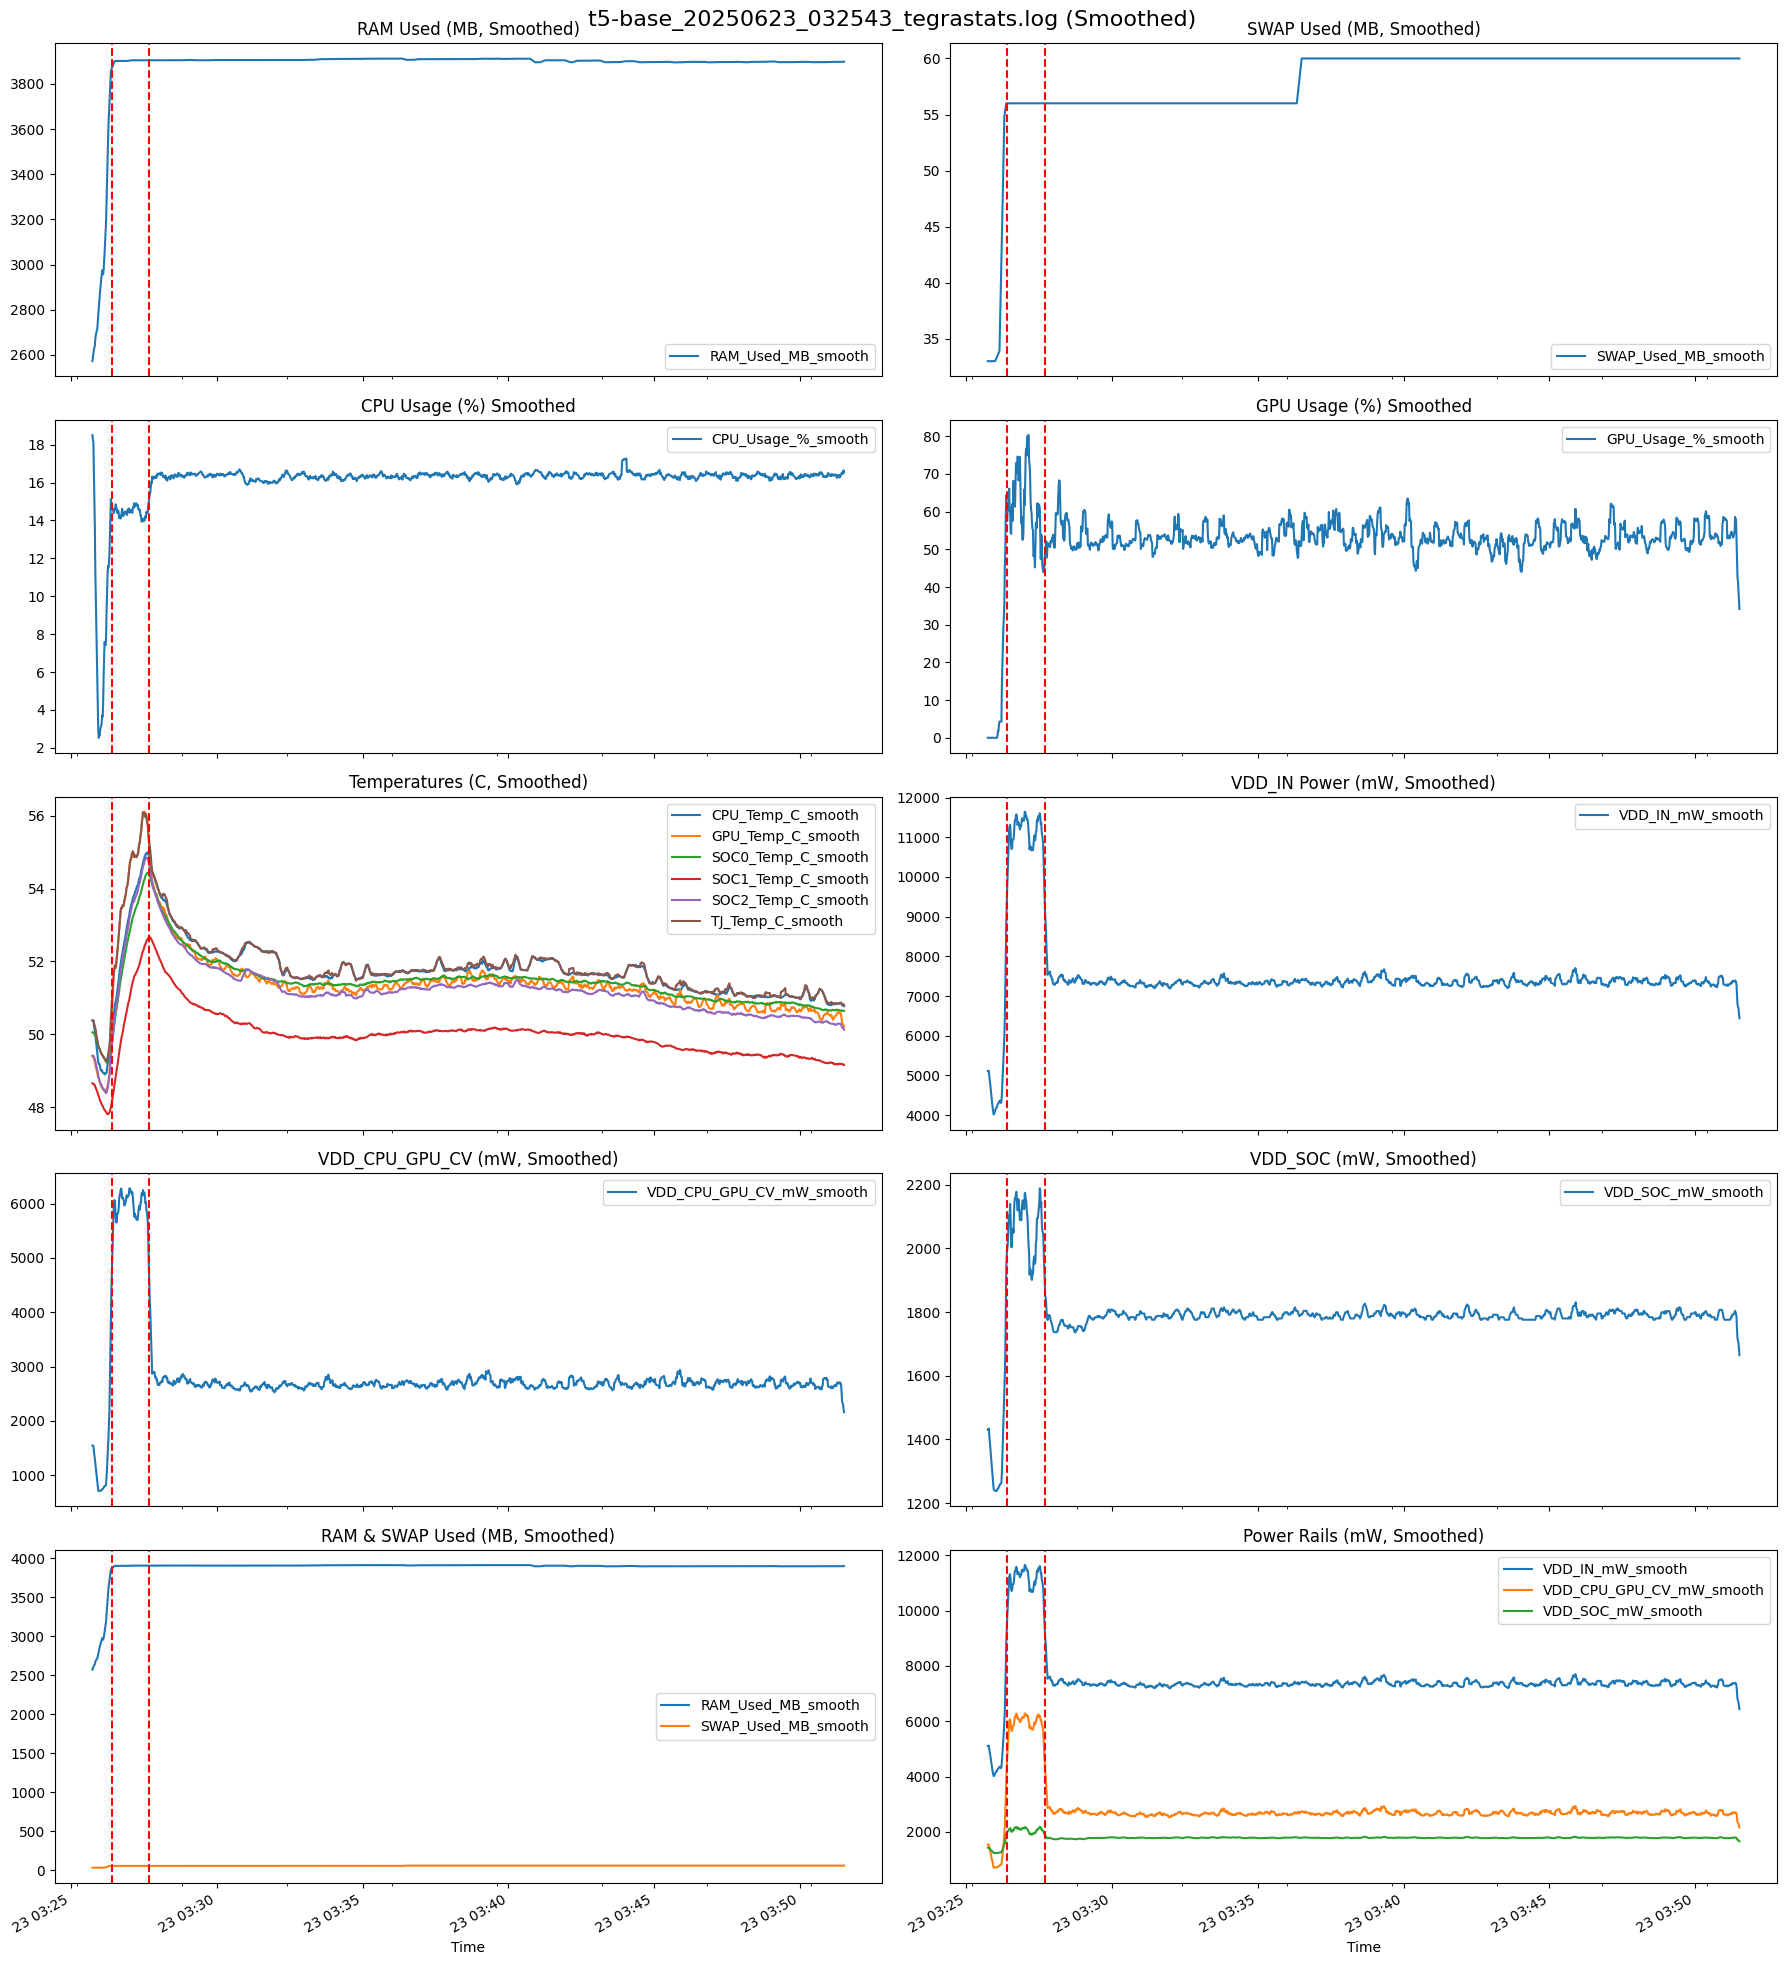

In [16]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator

def tegrastats_log_to_df(logfile):
    """
    Parse a tegrastats log file and return a pandas DataFrame with all relevant metrics.
    """
    import re
    import pandas as pd

    timestamps, ram_used, ram_total, swap_used, swap_total, cpu_avg, gr3d_freq = [], [], [], [], [], [], []
    cpu_temp, gpu_temp, soc0_temp, soc1_temp, soc2_temp, tj_temp = [], [], [], [], [], []
    vdd_in, vdd_cpu_gpu_cv, vdd_soc = [], [], []

    with open(logfile) as f:
        for line in f:
            # Timestamp
            ts = line[:19]
            timestamps.append(ts)
            # RAM used/total
            m = re.search(r'RAM (\d+)/(\d+)MB', line)
            ram_used.append(int(m.group(1)) if m else None)
            ram_total.append(int(m.group(2)) if m else None)
            # SWAP used/total
            m = re.search(r'SWAP (\d+)/(\d+)MB', line)
            swap_used.append(int(m.group(1)) if m else None)
            swap_total.append(int(m.group(2)) if m else None)
            # CPU average usage
            m = re.findall(r'CPU \[([^\]]+)\]', line)
            if m:
                cpu_vals = [int(x.split('%')[0]) for x in m[0].split(',')]
                cpu_avg.append(sum(cpu_vals)/len(cpu_vals))
            else:
                cpu_avg.append(None)
            # GPU freq
            m = re.search(r'GR3D_FREQ (\d+)%', line)
            gr3d_freq.append(int(m.group(1)) if m else None)
            # Temperatures
            m = re.search(r'cpu@([\d\.]+)C', line)
            cpu_temp.append(float(m.group(1)) if m else None)
            m = re.search(r'gpu@([\d\.]+)C', line)
            gpu_temp.append(float(m.group(1)) if m else None)
            m = re.search(r'soc0@([\d\.]+)C', line)
            soc0_temp.append(float(m.group(1)) if m else None)
            m = re.search(r'soc1@([\d\.]+)C', line)
            soc1_temp.append(float(m.group(1)) if m else None)
            m = re.search(r'soc2@([\d\.]+)C', line)
            soc2_temp.append(float(m.group(1)) if m else None)
            m = re.search(r'tj@([\d\.]+)C', line)
            tj_temp.append(float(m.group(1)) if m else None)
            # Power
            m = re.search(r'VDD_IN (\d+)mW', line)
            vdd_in.append(int(m.group(1)) if m else None)
            m = re.search(r'VDD_CPU_GPU_CV (\d+)mW', line)
            vdd_cpu_gpu_cv.append(int(m.group(1)) if m else None)
            m = re.search(r'VDD_SOC (\d+)mW', line)
            vdd_soc.append(int(m.group(1)) if m else None)

    df = pd.DataFrame({
        "Time": pd.to_datetime(timestamps),
        "RAM_Used_MB": ram_used,
        "RAM_Total_MB": ram_total,
        "SWAP_Used_MB": swap_used,
        "SWAP_Total_MB": swap_total,
        "CPU_Usage_%": cpu_avg,
        "GPU_Usage_%": gr3d_freq,
        "CPU_Temp_C": cpu_temp,
        "GPU_Temp_C": gpu_temp,
        "SOC0_Temp_C": soc0_temp,
        "SOC1_Temp_C": soc1_temp,
        "SOC2_Temp_C": soc2_temp,
        "TJ_Temp_C": tj_temp,
        "VDD_IN_mW": vdd_in,
        "VDD_CPU_GPU_CV_mW": vdd_cpu_gpu_cv,
        "VDD_SOC_mW": vdd_soc
    })
    return df

logfile = "../logs/edge/samsum/t5-base/t5-base_20250623_032543_tegrastats.log"
logfile_name = os.path.basename(logfile)

# Example: specify your 3 datetime strings here (replace with your actual datetimes)
vline_times = [
    "2025-06-23 03:26:23.257243",
    "2025-06-23 03:27:40.857561"
]

df = tegrastats_log_to_df(logfile)

vline_times = [pd.to_datetime(t) for t in vline_times]

fig, axs = plt.subplots(5, 2, figsize=(18, 20), sharex=True)
fig.suptitle(f"{logfile_name}", fontsize=16)
df.plot(x="Time", y="RAM_Used_MB", ax=axs[0,0], title="RAM Used (MB)")
df.plot(x="Time", y="SWAP_Used_MB", ax=axs[0,1], title="SWAP Used (MB)")
df.plot(x="Time", y="CPU_Usage_%", ax=axs[1,0], title="CPU Usage (%)")
df.plot(x="Time", y="GPU_Usage_%", ax=axs[1,1], title="GPU Usage (%)")
df.plot(x="Time", y=["CPU_Temp_C", "GPU_Temp_C", "SOC0_Temp_C", "SOC1_Temp_C", "SOC2_Temp_C", "TJ_Temp_C"], ax=axs[2,0], title="Temperatures (C)")
df.plot(x="Time", y="VDD_IN_mW", ax=axs[2,1], title="VDD_IN Power (mW)")
df.plot(x="Time", y="VDD_CPU_GPU_CV_mW", ax=axs[3,0], title="VDD_CPU_GPU_CV (mW)")
df.plot(x="Time", y="VDD_SOC_mW", ax=axs[3,1], title="VDD_SOC (mW)")
df.plot(x="Time", y=["RAM_Used_MB", "SWAP_Used_MB"], ax=axs[4,0], title="RAM & SWAP Used (MB)")
df.plot(x="Time", y=["VDD_IN_mW", "VDD_CPU_GPU_CV_mW", "VDD_SOC_mW"], ax=axs[4,1], title="Power Rails (mW)")

# Add vertical lines to all subplots
for ax_row in axs:
    for ax in ax_row:
        for vline in vline_times:
            ax.axvline(vline, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Smooth selected columns using a moving average
smooth_cols = [
    "RAM_Used_MB", "SWAP_Used_MB", "CPU_Usage_%", "GPU_Usage_%",
    "CPU_Temp_C", "GPU_Temp_C", "SOC0_Temp_C", "SOC1_Temp_C", "SOC2_Temp_C", "TJ_Temp_C",
    "VDD_IN_mW", "VDD_CPU_GPU_CV_mW", "VDD_SOC_mW"
]
window = 10  # Adjust window size as needed

for col in smooth_cols:
    df[f"{col}_smooth"] = df[col].rolling(window=window, min_periods=1, center=True).mean()

fig, axs = plt.subplots(5, 2, figsize=(18, 20), sharex=True)
fig.suptitle(f"{logfile_name} (Smoothed)", fontsize=16)
df.plot(x="Time", y="RAM_Used_MB_smooth", ax=axs[0,0], title="RAM Used (MB, Smoothed)")
df.plot(x="Time", y="SWAP_Used_MB_smooth", ax=axs[0,1], title="SWAP Used (MB, Smoothed)")
df.plot(x="Time", y="CPU_Usage_%_smooth", ax=axs[1,0], title="CPU Usage (%) Smoothed")
df.plot(x="Time", y="GPU_Usage_%_smooth", ax=axs[1,1], title="GPU Usage (%) Smoothed")
df.plot(
    x="Time",
    y=[f"{c}_smooth" for c in ["CPU_Temp_C", "GPU_Temp_C", "SOC0_Temp_C", "SOC1_Temp_C", "SOC2_Temp_C", "TJ_Temp_C"]],
    ax=axs[2,0], title="Temperatures (C, Smoothed)"
)
df.plot(x="Time", y="VDD_IN_mW_smooth", ax=axs[2,1], title="VDD_IN Power (mW, Smoothed)")
df.plot(x="Time", y="VDD_CPU_GPU_CV_mW_smooth", ax=axs[3,0], title="VDD_CPU_GPU_CV (mW, Smoothed)")
df.plot(x="Time", y="VDD_SOC_mW_smooth", ax=axs[3,1], title="VDD_SOC (mW, Smoothed)")
df.plot(x="Time", y=["RAM_Used_MB_smooth", "SWAP_Used_MB_smooth"], ax=axs[4,0], title="RAM & SWAP Used (MB, Smoothed)")
df.plot(
    x="Time",
    y=["VDD_IN_mW_smooth", "VDD_CPU_GPU_CV_mW_smooth", "VDD_SOC_mW_smooth"],
    ax=axs[4,1], title="Power Rails (mW, Smoothed)"
)

# Add vertical lines to all smoothed subplots
for ax_row in axs:
    for ax in ax_row:
        for vline in vline_times:
            ax.axvline(vline, color='red', linestyle='--')

plt.tight_layout()
plt.show()

C:\Users\sulta\AppData\Local\Temp\ipykernel_22624\3646906370.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
C:\Users\sulta\AppData\Local\Temp\ipykernel_22624\3646906370.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
C:\Users\sulta\AppData\Local\Temp\ipykernel_22624\3646906370.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
C:\Users\sulta\AppData\Local\Temp\ipykernel_22624\3646906370.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


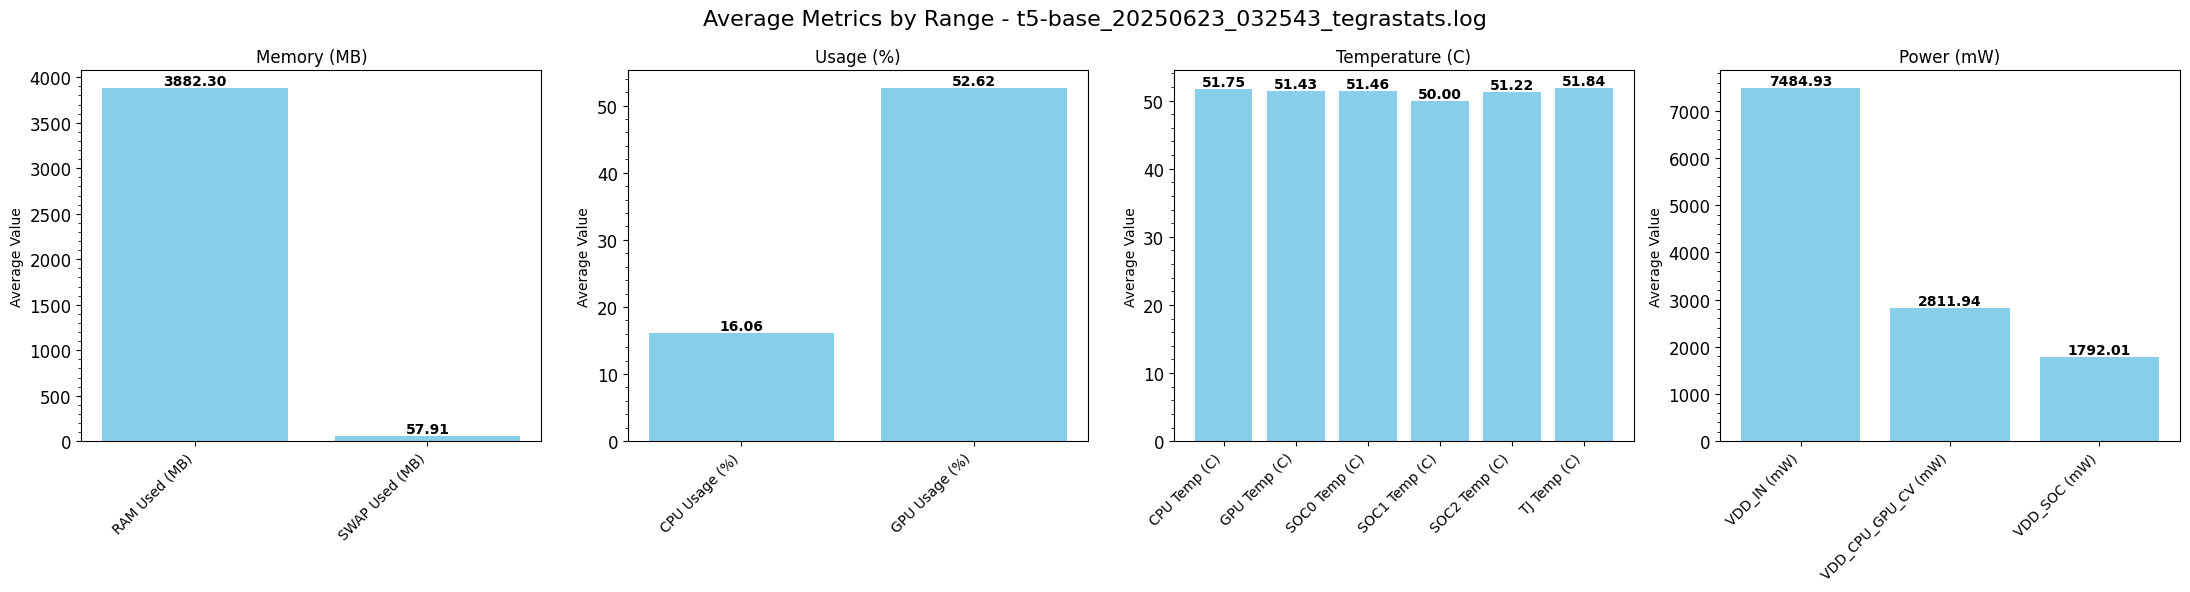

In [17]:
# --- New Cell ---
# Bar graph for average values of the metrics, separated by value range
# Group metrics by their value ranges for clearer visualization
metrics_groups = {
    "Memory (MB)": [
        ("RAM Used (MB)", df["RAM_Used_MB"].mean()),
        ("SWAP Used (MB)", df["SWAP_Used_MB"].mean()),
    ],
    "Usage (%)": [
        ("CPU Usage (%)", df["CPU_Usage_%"].mean()),
        ("GPU Usage (%)", df["GPU_Usage_%"].mean()),
    ],
    "Temperature (C)": [
        ("CPU Temp (C)", df["CPU_Temp_C"].mean()),
        ("GPU Temp (C)", df["GPU_Temp_C"].mean()),
        ("SOC0 Temp (C)", df["SOC0_Temp_C"].mean()),
        ("SOC1 Temp (C)", df["SOC1_Temp_C"].mean()),
        ("SOC2 Temp (C)", df["SOC2_Temp_C"].mean()),
        ("TJ Temp (C)", df["TJ_Temp_C"].mean()),
    ],
    "Power (mW)": [
        ("VDD_IN (mW)", df["VDD_IN_mW"].mean()),
        ("VDD_CPU_GPU_CV (mW)", df["VDD_CPU_GPU_CV_mW"].mean()),
        ("VDD_SOC (mW)", df["VDD_SOC_mW"].mean()),
    ]
}

fig, axs = plt.subplots(1, 4, figsize=(22, 6))
for ax, (group, items) in zip(axs, metrics_groups.items()):
    labels, values = zip(*items)
    bars = ax.bar(labels, values, color='skyblue')
    ax.set_title(group)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel('Average Value')
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='y', labelsize=12)
    # Print value on each bar
    for bar, value in zip(bars, values):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{value:.2f}",
            ha='center', va='bottom', fontsize=10, fontweight='bold'
        )

fig.suptitle(f'Average Metrics by Range - {logfile_name}', fontsize=16)
plt.tight_layout()
plt.show()

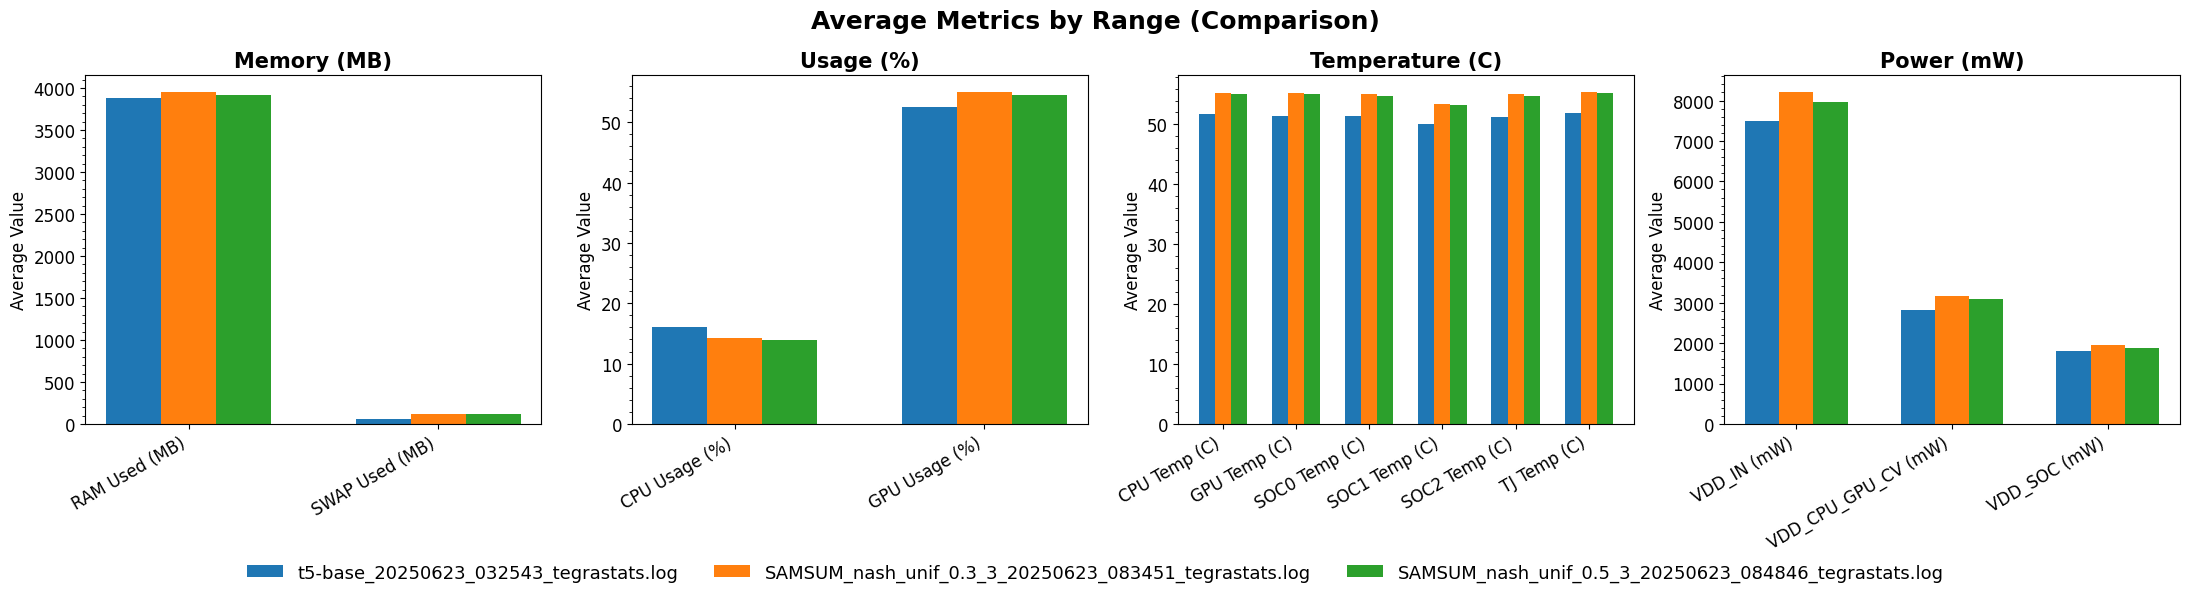

In [18]:
# --- New Cell ---
# Compare average values of metrics across 3 log files in grouped bar charts (same metrics and layout)
import numpy as np

logfiles = [
    "../logs/edge/samsum/t5-base/t5-base_20250623_032543_tegrastats.log",
    "../logs/edge/samsum/t5-base/SAMSUM_nash_unif_0.3_3_20250623_083451_tegrastats.log",
    "../logs/edge/samsum/t5-base/SAMSUM_nash_unif_0.5_3_20250623_084846_tegrastats.log"
]
logfile_names = [os.path.basename(f) for f in logfiles]
dfs = [tegrastats_log_to_df(f) for f in logfiles]

# Define metrics and groups
metrics_groups = {
    "Memory (MB)": [
        ("RAM Used (MB)", "RAM_Used_MB"),
        ("SWAP Used (MB)", "SWAP_Used_MB"),
    ],
    "Usage (%)": [
        ("CPU Usage (%)", "CPU_Usage_%"),
        ("GPU Usage (%)", "GPU_Usage_%"),
    ],
    "Temperature (C)": [
        ("CPU Temp (C)", "CPU_Temp_C"),
        ("GPU Temp (C)", "GPU_Temp_C"),
        ("SOC0 Temp (C)", "SOC0_Temp_C"),
        ("SOC1 Temp (C)", "SOC1_Temp_C"),
        ("SOC2 Temp (C)", "SOC2_Temp_C"),
        ("TJ Temp (C)", "TJ_Temp_C"),
    ],
    "Power (mW)": [
        ("VDD_IN (mW)", "VDD_IN_mW"),
        ("VDD_CPU_GPU_CV (mW)", "VDD_CPU_GPU_CV_mW"),
        ("VDD_SOC (mW)", "VDD_SOC_mW"),
    ]
}

fig, axs = plt.subplots(1, 4, figsize=(22, 6))
for ax, (group, items) in zip(axs, metrics_groups.items()):
    labels = [label for label, _ in items]
    n_metrics = len(items)
    x = np.arange(n_metrics)
    bar_width = 0.22

    # Gather means for each log file
    means = []
    for df in dfs:
        means.append([df[col].mean() for _, col in items])

    # Plot bars for each log file
    for i, (mean, name) in enumerate(zip(means, logfile_names)):
        bars = ax.bar(x + i*bar_width, mean, width=bar_width, label=name)
        # # Print value on each bar, angled and styled
        # for xi, val in zip(x + i*bar_width, mean):
        #     ax.text(
        #         xi, val, f"{val:.2f}",
        #         ha='center', va='bottom',
        #         fontsize=12, fontweight='bold',
        #         color='#2a4d69', rotation=45,
        #         bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2')
        #     )

    ax.set_title(group, fontsize=15, fontweight='bold')
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(labels, rotation=30, ha='right', fontsize=12)
    ax.set_ylabel('Average Value', fontsize=12)
    
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='y', labelsize=12)

# Only show one legend at the bottom center
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=len(logfile_names), fontsize=13, frameon=False)
fig.suptitle('Average Metrics by Range (Comparison)', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space for legend
plt.show()

In [19]:
# --- New Cell ---
# Table for ROUGE scores and latency data from terminal.log

import re
import pandas as pd

def extract_metrics_from_terminal_log(logfile):
    """
    Extract ROUGE and latency metrics from a terminal log file.
    Returns: (rouge1, rouge2, rougeL, rougeLsum, avg_ttft, avg_tgt, avg_tpot, avg_tps, avg_gen_len)
    """
    with open(logfile, "r") as f:
        text = f.read()

    # Extract ROUGE scores
    rouge1 = float(re.search(r'rouge1:\s*([0-9.]+)', text).group(1))
    rouge2 = float(re.search(r'rouge2:\s*([0-9.]+)', text).group(1))
    rougeL = float(re.search(r'rougeL:\s*([0-9.]+)', text).group(1))
    rougeLsum = float(re.search(r'rougeLsum:\s*([0-9.]+)', text).group(1))

    # Extract latency metrics (in ms or tokens/sec)
    avg_ttft = float(re.search(r'avg TTFT\s*:\s*([0-9.]+) ms', text).group(1))
    avg_tgt = float(re.search(r'avg TGT\s*:\s*([0-9.]+) ms', text).group(1))
    avg_tpot = float(re.search(r'avg TPOT\s*:\s*([0-9.]+) ms', text).group(1))
    avg_tps = float(re.search(r'avg TPS\s*:\s*([0-9.]+) tokens/sec', text).group(1))
    avg_gen_len = float(re.search(r'avg gen_len\s*:\s*([0-9.]+) tokens', text).group(1))

    return rouge1, rouge2, rougeL, rougeLsum, avg_ttft, avg_tgt, avg_tpot, avg_tps, avg_gen_len

# Usage example:
logfile = "../logs/edge/samsum/t5-base/t5-base_20250623_032543_terminal.log"
rouge1, rouge2, rougeL, rougeLsum, avg_ttft, avg_tgt, avg_tpot, avg_tps, avg_gen_len = extract_metrics_from_terminal_log(logfile)

# Prepare ROUGE data
rouge_data = {
    "Metric": ["ROUGE-1", "ROUGE-2", "ROUGE-L", "ROUGE-Lsum"],
    "Score": [rouge1, rouge2, rougeL, rougeLsum]
}
rouge_df = pd.DataFrame(rouge_data)

# Prepare latency data
latency_data = {
    "Metric": ["TTFT (ms)", "TGT (ms)", "TPOT (ms)", "TPS (tok/s)", "Gen Len"],
    "Value": [avg_ttft, avg_tgt, avg_tpot, avg_tps, avg_gen_len]
}
latency_df = pd.DataFrame(latency_data)

# Display tables
print("ROUGE Scores")
display(rouge_df)

print("Latency Metrics")
display(latency_df)

ROUGE Scores


,Metric,Score
0,ROUGE-1,0.2348
1,ROUGE-2,0.0695
2,ROUGE-L,0.1905
3,ROUGE-Lsum,0.1907


Latency Metrics


,Metric,Value
0,TTFT (ms),92.49
1,TGT (ms),1743.11
2,TPOT (ms),1733.63
3,TPS (tok/s),22.23
4,Gen Len,38.49


In [20]:
# --- New Cell ---
# Combine ROUGE and latency metrics from 3 terminal log files into one table

terminal_logfiles = [
    "../logs/edge/samsum/t5-base/t5-base_20250623_032543_terminal.log",
    "../logs/edge/samsum/t5-base/SAMSUM_nash_unif_0.3_3_20250623_083451_terminal.log",
    "../logs/edge/samsum/t5-base/SAMSUM_nash_unif_0.5_3_20250623_084846_terminal.log"
]
terminal_logfile_names = [os.path.basename(f) for f in terminal_logfiles]

def extract_metrics_from_terminal_log(logfile):
    with open(logfile, "r") as f:
        text = f.read()
    # Extract ROUGE scores
    rouge1 = float(re.search(r'rouge1:\s*([0-9.]+)', text).group(1))
    rouge2 = float(re.search(r'rouge2:\s*([0-9.]+)', text).group(1))
    rougeL = float(re.search(r'rougeL:\s*([0-9.]+)', text).group(1))
    rougeLsum = float(re.search(r'rougeLsum:\s*([0-9.]+)', text).group(1))
    # Extract latency metrics
    avg_ttft = float(re.search(r'avg TTFT\s*:\s*([0-9.]+) ms', text).group(1))
    avg_tgt = float(re.search(r'avg TGT\s*:\s*([0-9.]+) ms', text).group(1))
    avg_tpot = float(re.search(r'avg TPOT\s*:\s*([0-9.]+) ms', text).group(1))
    avg_tps = float(re.search(r'avg TPS\s*:\s*([0-9.]+) tokens/sec', text).group(1))
    avg_gen_len = float(re.search(r'avg gen_len\s*:\s*([0-9.]+) tokens', text).group(1))
    # Make TGT relative to generated tokens (ms/token)
    tgt_per_token = avg_tgt / avg_gen_len if avg_gen_len > 0 else float('nan')
    return [rouge1, rouge2, rougeL, rougeLsum, avg_ttft, avg_tgt, tgt_per_token, avg_tpot, avg_tps, avg_gen_len]

# Update metric names to include TGT per token
metric_names = [
    "ROUGE-1", "ROUGE-2", "ROUGE-L", "ROUGE-Lsum",
    "TTFT (ms)", "TGT (ms)", "TGT/ms/token", "TPOT (ms)", "TPS (tok/s)", "Gen Len"
]


# Collect metrics for all log files
all_metrics = []
for logfile in terminal_logfiles:
    all_metrics.append(extract_metrics_from_terminal_log(logfile))

combined_df = pd.DataFrame(all_metrics, columns=metric_names, index=terminal_logfile_names).T
combined_df.index.name = "Metric"
display(combined_df)

,t5-base_20250623_032543_terminal.log,SAMSUM_nash_unif_0.3_3_20250623_083451_terminal.log,SAMSUM_nash_unif_0.5_3_20250623_084846_terminal.log
Metric,,,
ROUGE-1,0.234800,0.468100,0.466500
ROUGE-2,0.069500,0.218800,0.219100
ROUGE-L,0.190500,0.382900,0.388100
ROUGE-Lsum,0.190700,0.382700,0.387700
TTFT (ms),92.490000,115.160000,119.180000
TGT (ms),1743.110000,853.790000,768.450000
TGT/ms/token,45.287347,30.265509,30.265853
TPOT (ms),1733.630000,844.650000,760.170000
TPS (tok/s),22.230000,34.770000,34.640000


Text(0.5, 1.0, 'Comparison of ROUGE and Latency Metrics Across Log Files')

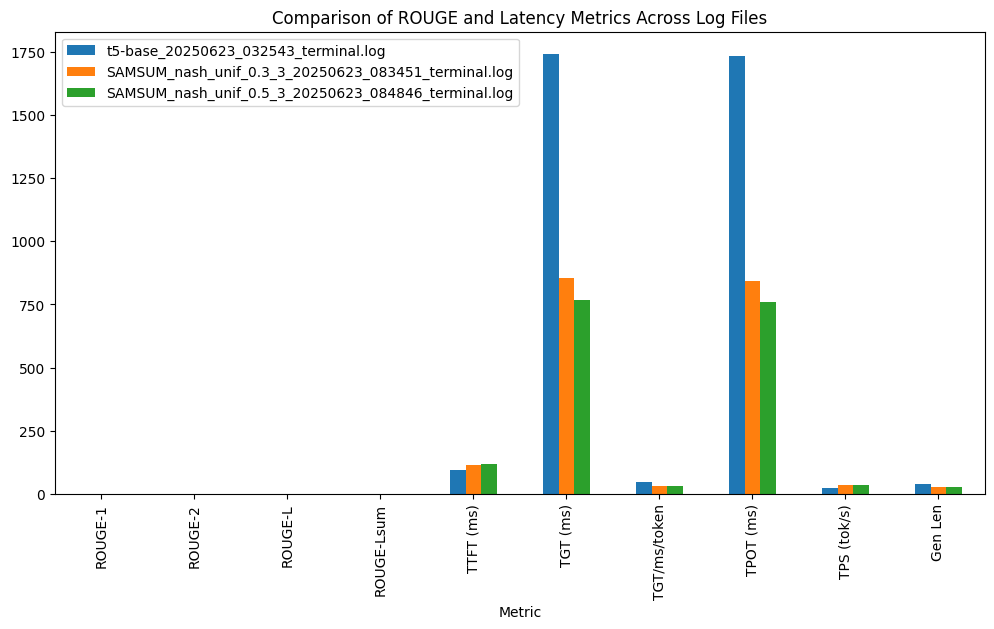

In [21]:
combined_df.plot(kind='bar', figsize=(12, 6))
plt.title('Comparison of ROUGE and Latency Metrics Across Log Files')

In [22]:
# --- New Cell ---
# Combine ROUGE and latency metrics from 3 terminal log files into one table, with a new column for relative TGT (ms/token)
import os
import re
import pandas as pd

terminal_logfiles = [
    "../logs/edge/samsum/t5-base/t5-base_20250623_032543_terminal.log",
    "../logs/edge/samsum/t5-base/SAMSUM_nash_unif_0.3_3_20250623_083451_terminal.log",
    "../logs/edge/samsum/t5-base/SAMSUM_nash_unif_0.5_3_20250623_084846_terminal.log"
]
terminal_logfile_names = [os.path.basename(f) for f in terminal_logfiles]

def extract_metrics_from_terminal_log(logfile):
    with open(logfile, "r") as f:
        text = f.read()
    # Extract ROUGE scores
    rouge1 = float(re.search(r'rouge1:\s*([0-9.]+)', text).group(1))
    rouge2 = float(re.search(r'rouge2:\s*([0-9.]+)', text).group(1))
    rougeL = float(re.search(r'rougeL:\s*([0-9.]+)', text).group(1))
    rougeLsum = float(re.search(r'rougeLsum:\s*([0-9.]+)', text).group(1))
    # Extract latency metrics
    avg_ttft = float(re.search(r'avg TTFT\s*:\s*([0-9.]+) ms', text).group(1))
    avg_tgt = float(re.search(r'avg TGT\s*:\s*([0-9.]+) ms', text).group(1))
    avg_tpot = float(re.search(r'avg TPOT\s*:\s*([0-9.]+) ms', text).group(1))
    avg_tps = float(re.search(r'avg TPS\s*:\s*([0-9.]+) tokens/sec', text).group(1))
    avg_gen_len = float(re.search(r'avg gen_len\s*:\s*([0-9.]+) tokens', text).group(1))
    # Make TGT relative to generated tokens (ms/token)
    tgt_per_token = avg_tgt / avg_gen_len if avg_gen_len > 0 else float('nan')
    return [rouge1, rouge2, rougeL, rougeLsum, avg_ttft, avg_tgt, avg_tpot, avg_tps, avg_gen_len, tgt_per_token]

# Update metric names to include TGT/ms/token as a new column at the end
metric_names = [
    "ROUGE-1", "ROUGE-2", "ROUGE-L", "ROUGE-Lsum",
    "TTFT (ms)", "TGT (ms)", "TPOT (ms)", "TPS (tok/s)", "Gen Len", "Relative TGT"
]

# Collect metrics for all log files
all_metrics = []
for logfile in terminal_logfiles:
    all_metrics.append(extract_metrics_from_terminal_log(logfile))

combined_df = pd.DataFrame(all_metrics, columns=metric_names, index=terminal_logfile_names).T
combined_df.index.name = "Metric"
display(combined_df)

,t5-base_20250623_032543_terminal.log,SAMSUM_nash_unif_0.3_3_20250623_083451_terminal.log,SAMSUM_nash_unif_0.5_3_20250623_084846_terminal.log
Metric,,,
ROUGE-1,0.234800,0.468100,0.466500
ROUGE-2,0.069500,0.218800,0.219100
ROUGE-L,0.190500,0.382900,0.388100
ROUGE-Lsum,0.190700,0.382700,0.387700
TTFT (ms),92.490000,115.160000,119.180000
TGT (ms),1743.110000,853.790000,768.450000
TPOT (ms),1733.630000,844.650000,760.170000
TPS (tok/s),22.230000,34.770000,34.640000
Gen Len,38.490000,28.210000,25.390000


In [23]:
# Split the combined_df into ROUGE and latency DataFrames
rouge_metrics = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "ROUGE-Lsum"]
latency_metrics = [
    "TTFT (ms)", "TGT (ms)", "TPOT (ms)", "TPS (tok/s)", "Gen Len", "Relative TGT"
]

rouge_df = combined_df.loc[rouge_metrics]
latency_df = combined_df.loc[latency_metrics]

display(rouge_df)
display(latency_df)

,t5-base_20250623_032543_terminal.log,SAMSUM_nash_unif_0.3_3_20250623_083451_terminal.log,SAMSUM_nash_unif_0.5_3_20250623_084846_terminal.log
Metric,,,
ROUGE-1,0.2348,0.4681,0.4665
ROUGE-2,0.0695,0.2188,0.2191
ROUGE-L,0.1905,0.3829,0.3881
ROUGE-Lsum,0.1907,0.3827,0.3877


,t5-base_20250623_032543_terminal.log,SAMSUM_nash_unif_0.3_3_20250623_083451_terminal.log,SAMSUM_nash_unif_0.5_3_20250623_084846_terminal.log
Metric,,,
TTFT (ms),92.490000,115.160000,119.180000
TGT (ms),1743.110000,853.790000,768.450000
TPOT (ms),1733.630000,844.650000,760.170000
TPS (tok/s),22.230000,34.770000,34.640000
Gen Len,38.490000,28.210000,25.390000
Relative TGT,45.287347,30.265509,30.265853


<Axes: title={'center': 'Latency Metrics Comparison'}, xlabel='Metric'>

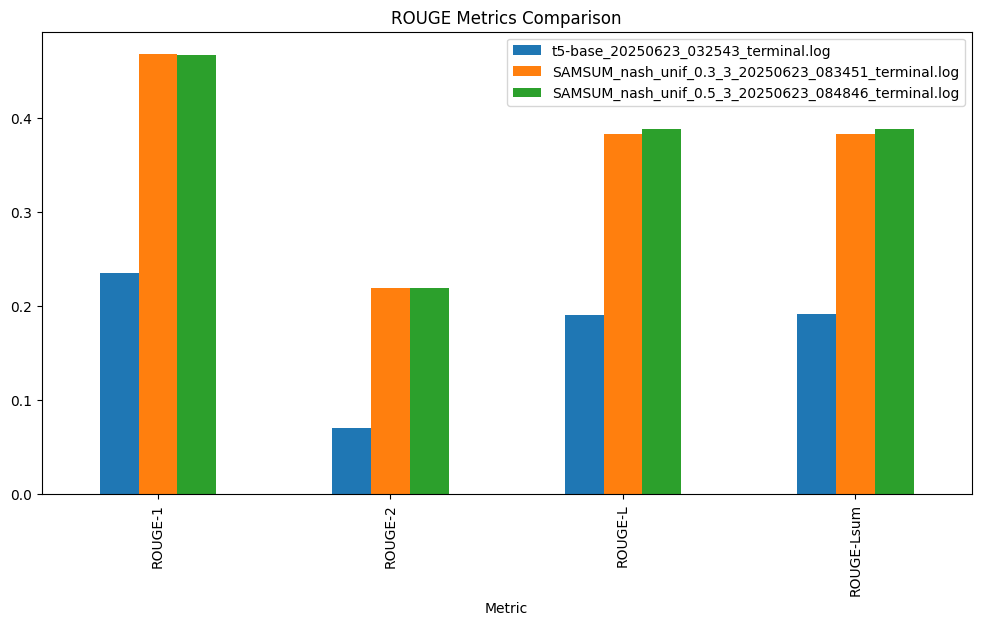

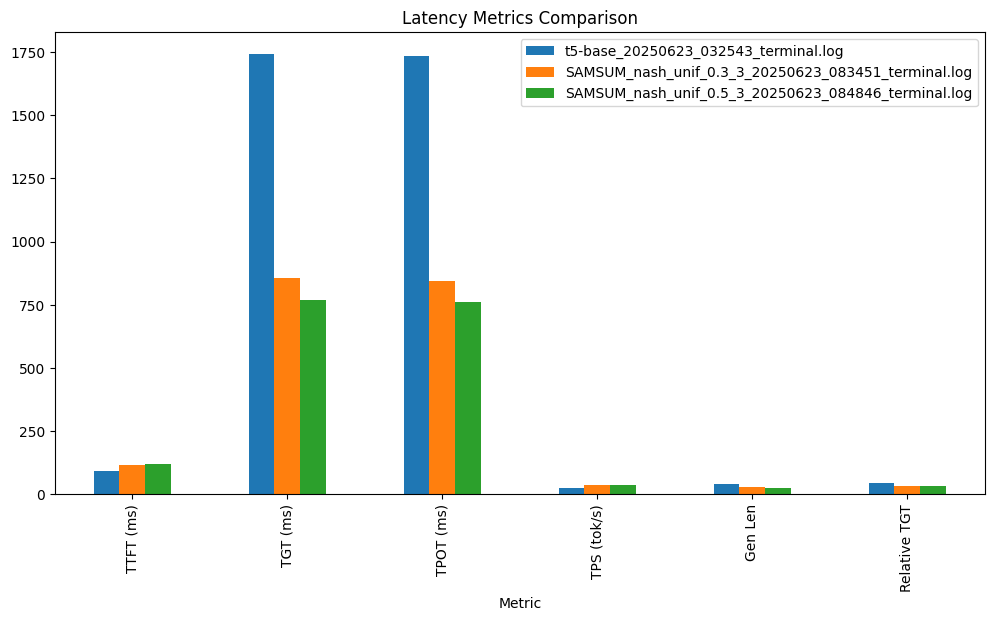

In [24]:
rouge_df.plot(kind='bar', figsize=(12, 6), title='ROUGE Metrics Comparison')
latency_df.plot(kind='bar', figsize=(12, 6), title='Latency Metrics Comparison')

In [26]:
latency_df[latency_df['Relative TGT']].plot(kind='bar', figsize=(12, 6), title='Relative TGT (ms/token) Comparison')


KeyError: 'Relative TGT'